<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 971.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU.csv')
data.sample(10)

,comment,toxic
5801,Он как-то раз подошел в двум здоровым чуркам. ...,1.0
2598,Ой герой нашелся! Да ты бы сам на все замки за...,1.0
11780,Да у нас полстраны в комплексах с советским во...,0.0
8558,"Насколько знаю, через электроприемную Прокурат...",0.0
9439,"У ритуалок везде куплено, и в полиции у конкре...",0.0
11584,Я не смотрела Доктора Хауса. Можешь начинать з...,1.0
14117,Эксперт уровня который мы заслужили вообще не ...,0.0
13551,Обе страны пытаются навязать свои планы другим...,0.0
4700,Вкратце - при монтаже и обслуживании ветряков ...,0.0
8731,"Во время сна - понятно, и это классно, потому ...",0.0


In [4]:
data['comment'] = data['comment'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


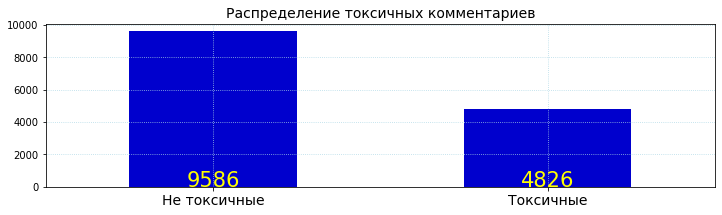

In [5]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
plt.show()

In [6]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [7]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize_word(word: str) -> str:
    try:
        p = morph.parse(word)[0]
        return p.normal_form 
    except:
        return word

In [8]:
def clear_and_lemmatize_text(text):
    text= text.lower()
    clear = re.sub(r'[^а-яА-Я]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[а-яА-Я]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join([lemmatize_word(word) for word in clear.split(' ')])

In [9]:
%%time
data['comment'] = data['comment'].apply(clear_and_lemmatize_text)

CPU times: user 1min 28s, sys: 397 ms, total: 1min 29s
Wall time: 1min 40s


In [10]:
data.sample(10)

,comment,toxic
6164,и что этот тоже переводчик но кроме перевод он...,0.0
2509,в япония такой панелька ебанько,0.0
3479,только поезд ехать час я на машина доезжать за,0.0
8755,в китай уже есть социальный рейтинг,0.0
6531,работать мастер зарплата на север уволиться ус...,0.0
6307,тред снова засраный ничего не чиститься никто ...,1.0
3784,у я максус три штука работать март год скоро т...,0.0
5667,читать это порнография всё равно что считать ...,1.0
1168,для ребёнок совсем другой атмосфера они очень ...,0.0
12542,какой адский боян залезать горячий,1.0


In [11]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
data=data.astype({'toxic': 'int64'})
data.to_csv(FILE_NAME_CLEAR_DATA, encoding='utf-8', index=False)
# files.download(FILE_NAME)

**Загружаем ощищенные данные**

In [12]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
df = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv')
df.sample(10)

,comment,toxic
1286,про менеджер автосалон я лично понравиться,0
12505,в ейский лиман можно уходить натурально точка ...,0
1030,так знать что это здесь быть твой куст какой с...,0
12164,за такой деньга только на бумага,0
10093,у я дом км от город маршрутка ходить машина есть,0
9669,от невзгода неудача мы помочь сткий кач,1
794,у я низкий интеллект тк резко пить,0
11890,ну где то мск мочь быть тут дуб ну пусть полку...,0
1580,а если кто то оскорблять сам себя ну ладный,0
2304,лахтадырой ольгинец лахта ольгино это который ...,1


**Взвесим tf-idf**

In [13]:
count_idf_neutral = TfidfVectorizer(min_df=3, max_df=0.8)
count_idf_toxic = TfidfVectorizer(min_df=3, max_df=0.8)

tf_idf_neutral = count_idf_neutral.fit_transform(df.query('toxic == 0')['comment'])
tf_idf_toxic = count_idf_toxic.fit_transform(df.query('toxic == 1')['comment'])

In [14]:
# Сохраним списки Idf для каждого класса
neutral_importance = pd.DataFrame(
    {'word' : count_idf_neutral.get_feature_names_out(),
     'idf' : count_idf_neutral.idf_
    }).sort_values(by = 'idf', ascending = False)

toxic_importance = pd.DataFrame(
    {'word' : count_idf_toxic.get_feature_names_out(),
     'idf' : count_idf_toxic.idf_
    }).sort_values(by = 'idf', ascending = False)

In [15]:
neutral_importance.head(10) 

,word,idf
0,аба,8.781869
5180,прижать,8.781869
1799,закурить,8.781869
1801,зала,8.781869
5199,прикрываться,8.781869
1805,залипать,8.781869
5192,приказать,8.781869
5184,признание,8.781869
1813,замереть,8.781869
5164,пригодный,8.781869


In [16]:
toxic_importance.head(10)

,word,idf
0,аборт,8.095686
2540,подменить,8.095686
2547,подонок,8.095686
979,жёлчь,8.095686
2552,подписывать,8.095686
975,журналистика,8.095686
2557,подрочить,8.095686
2563,подстилка,8.095686
2564,подтвердить,8.095686
967,жирух,8.095686


**Разделение выборок, преобразование текстов**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=7)

**Векторизация текста**

In [18]:
vectorize = TfidfVectorizer(min_df=3, max_df=0.8)

In [19]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

**LogisticRegression**

In [20]:
clf = LogisticRegression(solver = 'lbfgs',
                                    random_state = 21,
                                    max_iter= 10000,
                                    n_jobs= -1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=21)

**Save model**

In [21]:
import joblib
joblib_file = "LogisticRegressionModel.pkl"
joblib.dump(clf, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = joblib_model.predict(X_test)

Test score: 87.37 %


In [22]:
pred = clf.predict(X_test)

**Отобразим матрицу ошибок**

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred))) 
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4)) 
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 87.37 %
Recall: 70.03 %
Precision: 90.75 %
F1-score: 79.06 % 

precision: 0.8846209290274154, recall: 0.8317512227592394, f1score: 0.8500982192546307
              precision    recall  f1-score   support

           0     0.8617    0.9632    0.9096      1902
           1     0.9075    0.7003    0.7906       981

    accuracy                         0.8737      2883
   macro avg     0.8846    0.8318    0.8501      2883
weighted avg     0.8773    0.8737    0.8691      2883

True Negatives:  1832
False Positives:  70
False Negatives:  294
True Positives:  687


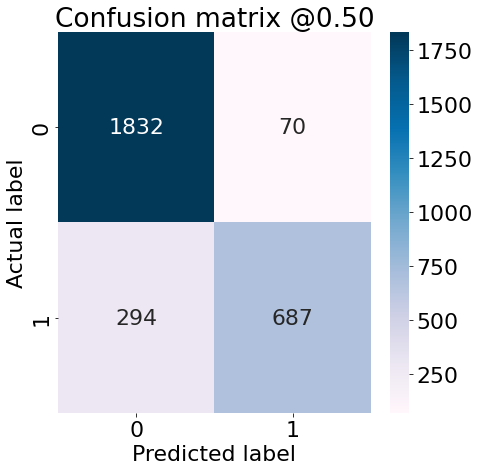

In [24]:
plot_cm(y_test, pred)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1902
           1       0.91      0.70      0.79       981

    accuracy                           0.87      2883
   macro avg       0.88      0.83      0.85      2883
weighted avg       0.88      0.87      0.87      2883



#**Отобразим топ нейтральных и токсичных слов в текстах датасета**

In [26]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 12))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=1600
    HEIGHT=1600
    
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Blues',
                          max_words=200,
                          mask=None
                          ).generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Oranges',
                          max_words=200,
                          mask=None, 
                          ).generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [27]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), clf.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])

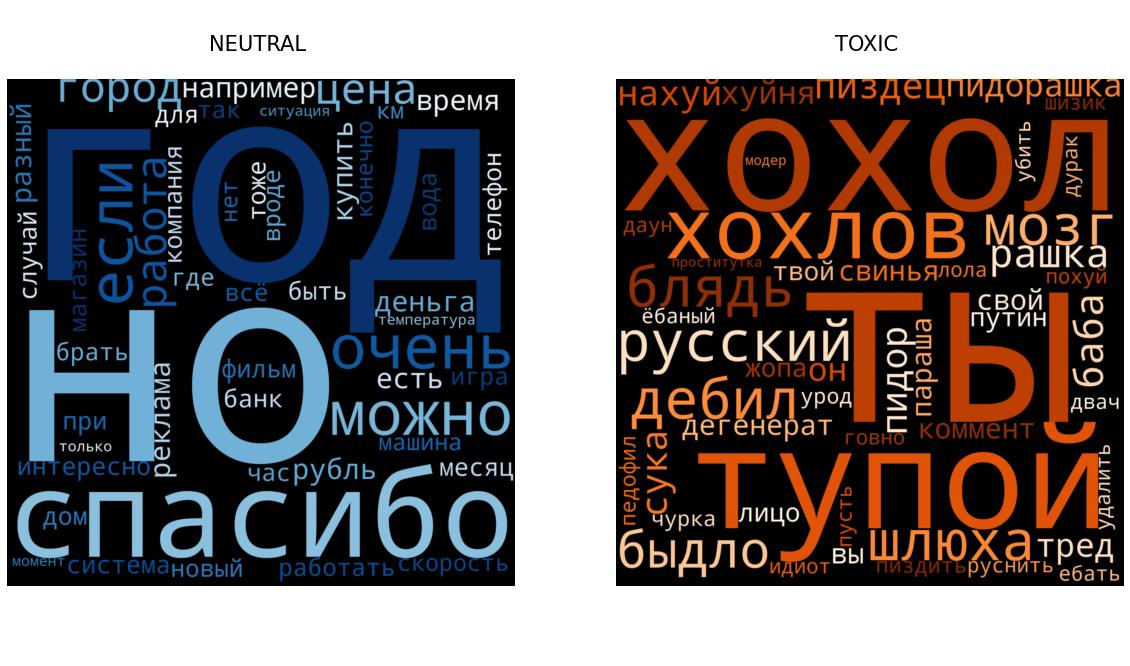

In [28]:
wordplot(toxic, neutral)